In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
from astropy import units as u
import sys
import pandas as pd
import extinction

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
nii6584 = hdu[1].data['NII_6584_FLUX'].tolist()
nii6584_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()
oii3727 = hdu[1].data['OII_3727_FLUX'].tolist()
oii3727_err = hdu[1].data['OII_3727_FLUX_ERR'].tolist()
oiii5007 = hdu[1].data['OIII_5007_FLUX'].tolist()
oiii5007_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err',
             'nii6584', 'nii6584_err', 'oii3727', 'oii3727_err', 
             'oiii5007', 'oiii5007_err', 
             'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 
            'nii6584':nii6584, 'nii6584_err':nii6584_err, 
            'oii3727':oii3727, 'oii3727_err':oii3727_err, 
            'oiii5007':oiii5007, 'oiii5007_err':oiii5007_err, 
            'z':z}

df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
# Making SNR cuts
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['nii6584']/df['nii6584_err']) > 3]
df = df.loc[(df['oii3727']/df['oii3727_err']) > 3]
df = df.loc[(df['oiii5007']/df['oiii5007_err']) > 3]

df = df.query('z > 0.2 & z <=0.3')

In [7]:
ly_a_lam = 0.121524
nv_lam = 0.1240
civ_lam = 0.1550
heii_lam = 0.1640
ciii_lam = 0.1909
mgii_lam = 0.2800
oii_lam = 0.3727
neiii_lam = 0.3869
h_ep_lam = 0.3971
h_gamma_lam = 0.434168
oiii_4363_lam = 0.4363
hb_lam = 0.486268
oiii_4959_lam = 0.4959
oiii_5007_lam = 0.5007
ha_lam = 0.65646
nii_lam = 0.6584
sii_lam = 0.6717

In [8]:
def ext_k(lam):
    """compute the value of the reddening curve for wavelength lam
    Parameters
    ==========
    lam : float
        wavelength [mu]
    """
    klam = -4.12 + (2.56/(lam)) + (-0.152/(lam**2)) + (0.0104/(lam**3)) + 2.93
    return klam

In [9]:
def ext_dk(lam1, lam2):
    """compute the differential reddening between two wavelengths
    Parameters
    ==========
    lam1, lam2 : float
        wavelength [mu]
    """
    dk = ext_k(lam1) - ext_k(lam2)
    return dk

In [10]:
def ext_ebv_from_ratios(lam1, lam2, rth, robs, recip=False):
    """compute B-V color excess of two lines with known intrinsic flux ratio
    
    Parameters
    ==========
    lam1 : float
        wavelength [mu] of line 1
    lam2 : float
        wavelength [mu] of line 2
    rth : float
        theoretical ratio f2 / f1
    robs : float
        observed ratio f2 / f1
    recip : bool
        if True, rth and robs are assumed provided as f1 / f2
    """
    if recip:
        rth, robs = 1. / rth, 1. / robs
    ebv = (2.5 / ext_dk(lam1, lam2)) * np.log10(robs / rth)
    return ebv

In [11]:
def extinguish(lam, ebv):
    """apply extinction law with known color excess
    
    to extinguish, multiply flux with the output of this function;
        to remove extinction, divide by the output of this function
    
    Parameters
    ==========
    lam : float
        wavelength [mu] to evaluate attenuation law at
    ebv : float
        known color excess
    """
    A_lam = ext_k(lam) * ebv
    ext_factor = 10.**(-0.4 * A_lam)
    return ext_factor

In [12]:
calc_ebv = ext_ebv_from_ratios(hb_lam, ha_lam, 2.86, (df['ha']/df['hb']), recip=False)
df['ebv'] = calc_ebv
df

,ha,ha_err,hb,hb_err,nii6584,nii6584_err,oii3727,oii3727_err,oiii5007,oiii5007_err,z,ebv
29,53.094452,1.977745,9.892110,1.334563,12.758877,1.134638,27.533510,1.807330,9.458583,1.202161,0.228498,0.605679
61,46.662724,1.139682,9.928170,0.848596,9.678543,1.180141,33.591476,1.498797,30.265347,1.003380,0.286323,0.477940
134,192.825790,3.421584,38.741592,1.445693,64.135101,2.383138,68.077065,2.333494,15.749771,1.258931,0.202274,0.533074
263,81.637802,2.347409,15.723496,1.595534,22.234880,1.482561,46.667141,2.047205,16.148912,1.358374,0.228571,0.573737
365,199.151581,2.685835,40.898823,1.353375,55.779964,13.600511,84.066696,2.241698,17.741524,1.123096,0.202244,0.511995
...,...,...,...,...,...,...,...,...,...,...,...,...
1905070,48.886604,2.554159,9.197604,2.277733,17.022465,2.099779,19.025949,2.972879,8.607370,1.508413,0.297303,0.596274
1905980,13.684256,1.751517,5.070052,1.673412,11.055016,3.302495,10.588248,2.517611,11.355833,2.008065,0.209664,-0.055733
1908641,14.411279,0.769568,5.136702,0.769681,2.286608,0.656752,14.311701,1.119756,13.420925,0.898272,0.236951,-0.018494
1909214,22.662544,1.031262,6.187484,0.963813,6.653000,0.874794,13.459713,1.178641,3.812175,0.818247,0.297814,0.237998


In [13]:
ha_ext = extinguish(ha_lam, df['ebv'])
hb_ext = extinguish(hb_lam, df['ebv'])
nii_ext = extinguish(nii_lam, df['ebv'])
oii_ext = extinguish(oii_lam, df['ebv'])
oiii_5007_ext = extinguish(oiii_5007_lam, df['ebv'])

In [14]:
ha_cor = df['ha']/ha_ext
hb_cor = df['hb']/hb_ext
nii_cor = df['nii6584']/nii_ext
oii_cor = df['oii3727']/oii_ext
oiii_5007_cor = df['oiii5007']/oiii_5007_ext

In [15]:
print(len(ha_cor))
print(len(hb_cor))
print(len(nii_cor))
print(len(oii_cor))
print(len(oiii_5007_cor))

12503
12503
12503
12503
12503


In [16]:
def groves_1():
    x = np.linspace(-2, 2, 500)
    y = 2.1*x + 0.85
    return [x, y]

def groves_2():
    x = np.linspace(-2, 2, 500)
    y = -1.2*x - 0.7
    return [x, y]

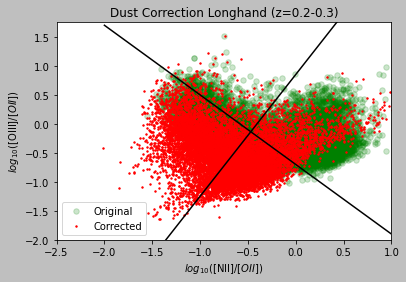

In [17]:
plt.style.use('grayscale')
x = np.log10(nii_cor/oii_cor)
y = np.log10(oiii_5007_cor/oii_cor)

x2 = np.log10(df['nii6584']/df['oii3727'])
y2 = np.log10(df['oiii5007']/df['oii3727'])

plt.plot(groves_1()[0], groves_1()[1], c='black')
plt.plot(groves_2()[0], groves_2()[1], c='black')

plt.xlim(-2.50,1.0)
plt.ylim(-2.0,1.75)

reg = plt.scatter(x2, y2, c='g', s=30, alpha=0.2)
cor = plt.scatter(x, y, c='r', s=2)

plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
plt.title('Dust Correction Longhand (z=0.2-0.3)')

plt.legend((reg, cor), ('Original', 'Corrected'))

plt.show()

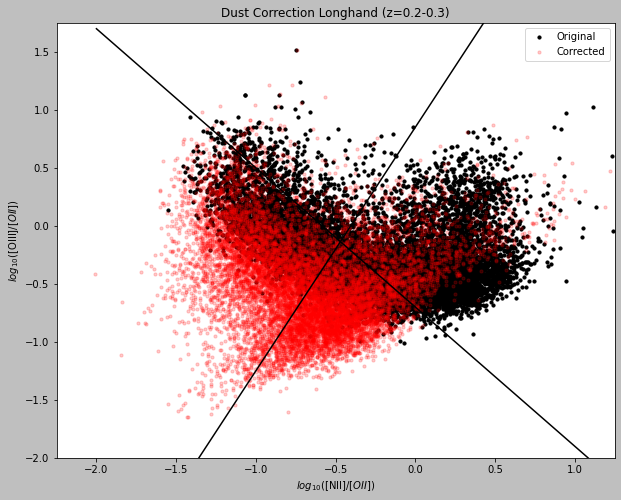

In [30]:
plt.style.use('grayscale')
plt.figure(figsize=(10, 8))
x = np.log10(nii_cor/oii_cor)
y = np.log10(oiii_5007_cor/oii_cor)

x2 = np.log10(df['nii6584']/df['oii3727'])
y2 = np.log10(df['oiii5007']/df['oii3727'])

plt.plot(groves_1()[0], groves_1()[1], c='black')
plt.plot(groves_2()[0], groves_2()[1], c='black')

plt.xlim(-2.25,1.25)
plt.ylim(-2.0,1.75)

reg = plt.scatter(x2, y2, c='k', s=10)
cor = plt.scatter(x, y, c='r', s=10, alpha=0.2)

plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
plt.title('Dust Correction Longhand (z=0.2-0.3)')

plt.legend((reg, cor), ('Original', 'Corrected'))

plt.show()

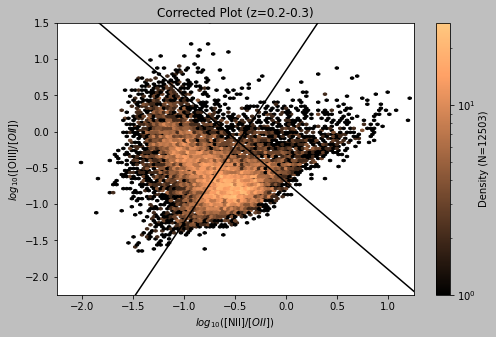

In [19]:
plt.style.use('grayscale')
x = np.log10(nii_cor/oii_cor)
y = np.log10(oiii_5007_cor/oii_cor)

x2 = np.log10(df['nii6584']/df['oii3727'])
y2 = np.log10(df['oiii5007']/df['oii3727'])

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)  
correct = ax.hexbin(x, y, gridsize = 100, cmap = "copper", bins = "log", mincnt = 1)
cb = fig.colorbar(correct, ax=ax)
cb.set_label('Density (N=12503)')

plt.plot(groves_1()[0], groves_1()[1], c='black')
plt.plot(groves_2()[0], groves_2()[1], c='black')

plt.xlim(-2.25,1.25)
plt.ylim(-2.25,1.50)

#reg = plt.scatter(x2, y2, c='g', s=30, alpha=0.2)
#cor = plt.scatter(x, y, c='r', s=5)

plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
plt.title('Corrected Plot (z=0.2-0.3)')

#plt.legend((reg, cor), ('Original', 'Corrected'))

plt.show()

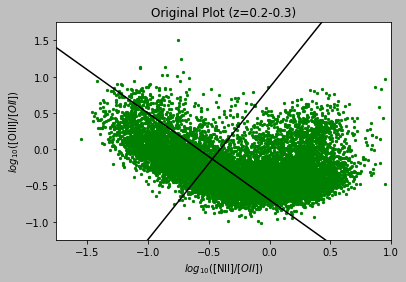

In [20]:
plt.style.use('grayscale')
#x = np.log10(nii6584_2/oii3727_2)
#y = np.log10(oiii5007_2/oii3727_2)

x2 = np.log10(df['nii6584']/df['oii3727'])
y2 = np.log10(df['oiii5007']/df['oii3727'])

plt.plot(groves_1()[0], groves_1()[1], c='black')
plt.plot(groves_2()[0], groves_2()[1], c='black')

plt.xlim(-1.75,1.0)
plt.ylim(-1.25,1.75)

reg = plt.scatter(x2, y2, c='g', s=5)
#cor = plt.scatter(x, y, c='r', s=2)

plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
plt.title('Original Plot (z=0.2-0.3)')

#plt.legend((reg, cor), ('Original', 'Corrected'))

plt.show()

In [21]:
cor_data = {'ha_cor':ha_cor, 'hb_cor':hb_cor, 
           'nii_cor':nii_cor, 'oii_cor':oii_cor, 'oiii_5007_cor':oiii_5007_cor, 
           'z':df['z'], 'ebv':df['ebv']}
df_cor = pd.DataFrame(cor_data)
df_cor

,ha_cor,hb_cor,nii_cor,oii_cor,oiii_5007_cor,z,ebv
29,201.830300,70.570035,48.238096,397.402456,63.008886,0.228498,0.605679
61,133.843556,46.798446,27.642384,276.111811,135.153633,0.286323,0.477940
134,624.573533,218.382354,206.746218,713.498137,83.584462,0.202274,0.533074
263,289.230631,101.129591,78.370516,585.111090,97.338794,0.228571,0.573737
365,615.770896,215.304509,171.679754,802.911139,88.141416,0.202244,0.511995
...,...,...,...,...,...,...,...
1905070,182.021327,63.643821,63.042290,263.459289,55.674762,0.297303,0.596274
1905980,12.101979,4.231461,9.781640,8.282111,9.537511,0.209664,-0.055733
1908641,13.835490,4.837584,2.195613,13.191396,12.665874,0.236951,-0.018494
1909214,38.299352,13.391382,11.219490,38.424010,8.031411,0.297814,0.237998


In [22]:
def low_met_agn(df_cor): 
    x_values = df_cor.x.values
    y_values = df_cor.y.values.tolist()
    
    z_1 = df_cor['z'].values
    ha_1 = df_cor['ha_cor'].values
    hb_1 = df_cor['hb_cor'].values
    oiii5007_1 = df_cor['oiii_5007_cor'].values
    nii6584_1 = df_cor['nii_cor'].values
    oii3727_1 = df_cor['oii_cor'].values
    ebv_1 = df_cor['ebv'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df_cor.loc[:,"z"].median())))+1.4+0.03*(df_cor.loc[:,"z"].median())
    
    df_cor1 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df_cor1.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df_cor1.append('agn')
        elif x > 0.0:
            df_cor1.append('agn')
        else: 
            df_cor1.append('starform')
            
    return df_cor1, ha_1,  hb_1, nii6584_1, oiii5007_1, oii3727_1, z_1, ebv_1

In [23]:
df_cor['x'] = np.log10(df_cor['nii_cor']/df_cor['ha_cor'])
df_cor['y'] = np.log10(df_cor['oiii_5007_cor']/df_cor['hb_cor'])

df_cor1 = low_met_agn(df_cor)

In [24]:
df_cor1 = pd.DataFrame(df_cor1)
df_cor1 = df_cor1.transpose()
df_cor1.columns = ['Type', 'ha', 'hb', 'n2', 'o3', 'o2', 'z', 'ebv']
df_cor1

,Type,ha,hb,n2,o3,o2,z,ebv
0,starform,201.83,70.57,48.2381,63.0089,397.402,0.228498,0.605679
1,starform,133.844,46.7984,27.6424,135.154,276.112,0.286323,0.47794
2,starform,624.574,218.382,206.746,83.5845,713.498,0.202274,0.533074
3,starform,289.231,101.13,78.3705,97.3388,585.111,0.228571,0.573737
4,starform,615.771,215.305,171.68,88.1414,802.911,0.202244,0.511995
...,...,...,...,...,...,...,...,...
12498,starform,182.021,63.6438,63.0423,55.6748,263.459,0.297303,0.596274
12499,agn,12.102,4.23146,9.78164,9.53751,8.28211,0.209664,-0.0557335
12500,starform,13.8355,4.83758,2.19561,12.6659,13.1914,0.236951,-0.018494
12501,starform,38.2994,13.3914,11.2195,8.03141,38.424,0.297814,0.237998


In [25]:
dfagn_cor = df_cor1[df_cor1.Type != 'starform']
dfsf_cor = df_cor1[df_cor1.Type != 'agn']
dflowmetagn_cor = df_cor1[df_cor1.Type != 'agn']

dfagn_cor = dfagn_cor[dfagn_cor.Type != 'lowmetagn']
dfsf_cor = dfsf_cor[dfsf_cor.Type != 'lowmetagn']
dflowmetagn_cor = dflowmetagn_cor[dflowmetagn_cor.Type != 'starform']

In [26]:
def plot_bpt_1(nii,oii,oiii,nii2,oii2,oiii2,nii3,oii3,oiii3,fig=None,**kwargs):
    oii=np.array(oii,dtype=float)
    oii2=np.array(oii2,dtype=float)
    oii3=np.array(oii3, dtype=float)
    nii=np.array(nii,dtype=float)
    nii2=np.array(nii2,dtype=float)
    nii3=np.array(nii3,dtype=float)
    oiii=np.array(oiii,dtype=float)
    oiii2=np.array(oiii2,dtype=float)
    oiii3=np.array(oiii3,dtype=float)
    n2o2=np.log10(nii/oii)
    o3o2=np.log10(oiii/oii)
    n2o22=np.log10(nii2/oii2)
    o3o22=np.log10(oiii2/oii2)
    n2o23=np.log10(nii3/oii3)
    o3o23=np.log10(oiii3/oii3)
    
    plt.style.use('grayscale')
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    
    starform = ax.hexbin(n2o2, o3o2, gridsize = 100, cmap = "copper", bins = "log", mincnt = 1)
    low_met_agn = plt.scatter(n2o22,o3o22, c='r', s=30, **kwargs)
    agn = ax.hexbin(n2o23, o3o23, gridsize = 100, cmap = "winter", bins = "log", mincnt = 1)
    
    plt.plot(groves_1()[0], groves_1()[1], c='black')
    plt.plot(groves_2()[0], groves_2()[1], c='black')
    
    cb = fig.colorbar(agn, ax=ax)
    cb2 = fig.colorbar(starform, ax=ax)
    cb.set_label(r'$log_{10}(N)$ (AGNs)')
    cb2.set_label(r'$log_{10}(N)$ (Starforming)')
    
    plt.xlim(-2.25,1.25)
    plt.ylim(-2.25,1.50)
    plt.title('Median Z~0.250 -- Universe 10.5 Gyr Old')
    plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
    plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
    plt.show()
    return

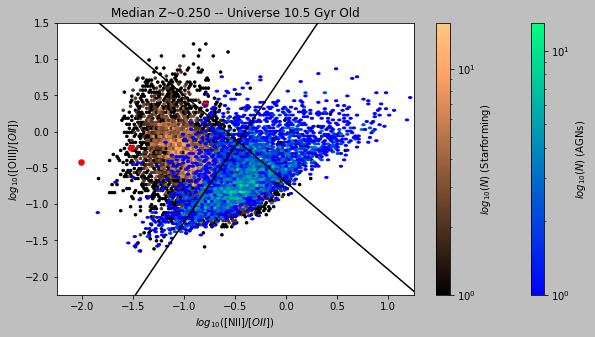

In [27]:
oii = dfsf_cor['o2'].values
oii2 = dflowmetagn_cor['o2'].values
oii3 = dfagn_cor['o2'].values
nii = dfsf_cor['n2'].values
nii2 = dflowmetagn_cor['n2'].values
nii3 = dfagn_cor['n2'].values
oiii = dfsf_cor['o3'].values
oiii2 = dflowmetagn_cor['o3'].values
oiii3 = dfagn_cor['o3'].values

plot_bpt_1(nii, oii, oiii, nii2, oii2, oiii2, nii3, oii3, oiii3, alpha = 1.0)

In [28]:
def plot_bpt_2(nii,oii,oiii,nii2,oii2,oiii2,nii3,oii3,oiii3,fig=None,**kwargs):
    oii=np.array(oii,dtype=float)
    oii2=np.array(oii2,dtype=float)
    oii3=np.array(oii3, dtype=float)
    nii=np.array(nii,dtype=float)
    nii2=np.array(nii2,dtype=float)
    nii3=np.array(nii3,dtype=float)
    oiii=np.array(oiii,dtype=float)
    oiii2=np.array(oiii2,dtype=float)
    oiii3=np.array(oiii3,dtype=float)
    n2o2=np.log10(nii/oii)
    o3o2=np.log10(oiii/oii)
    n2o22=np.log10(nii2/oii2)
    o3o22=np.log10(oiii2/oii2)
    n2o23=np.log10(nii3/oii3)
    o3o23=np.log10(oiii3/oii3)
    
    plt.style.use('grayscale')
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    
    starform = ax.hexbin(n2o2, o3o2, gridsize = (300, 300), cmap = "copper", bins = "log", mincnt = 1)
    low_met_agn = plt.scatter(n2o22,o3o22, c='r', s=30, **kwargs)
    agn = ax.hexbin(n2o23, o3o23, gridsize = (300, 300), cmap = "winter", bins = "log", mincnt = 1)
    
    plt.plot(groves_1()[0], groves_1()[1], c='black')
    plt.plot(groves_2()[0], groves_2()[1], c='black')
    
    cb = fig.colorbar(agn, ax=ax)
    cb2 = fig.colorbar(starform, ax=ax)
    cb.set_label(r'$log_{10}(N)$ (AGNs)')
    cb2.set_label(r'$log_{10}(N)$ (Starforming)')
    
    plt.xlim(-2.25,1.25)
    plt.ylim(-2.25,1.50)
    plt.title('Median Z~0.250 -- Universe 10.5 Gyr Old')
    plt.xlabel(r'$log_{10}($[NII]/$[OII])$')
    plt.ylabel(r'$log_{10}($[OIII]/$[OII])$')
    plt.show()
    return

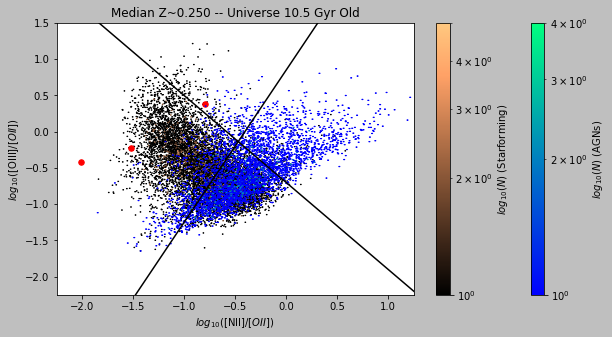

In [29]:
oii = dfsf_cor['o2'].values
oii2 = dflowmetagn_cor['o2'].values
oii3 = dfagn_cor['o2'].values
nii = dfsf_cor['n2'].values
nii2 = dflowmetagn_cor['n2'].values
nii3 = dfagn_cor['n2'].values
oiii = dfsf_cor['o3'].values
oiii2 = dflowmetagn_cor['o3'].values
oiii3 = dfagn_cor['o3'].values

plot_bpt_2(nii, oii, oiii, nii2, oii2, oiii2, nii3, oii3, oiii3, alpha = 1.0)